## A life-cycle consumption model with a discrete choice

- author: Tao Wang
- date: September 2021
- this is an companion notebook to the paper "Perceived income risks"

This notebook extends the [notebook](SolveLifeCycle.ipynb) that solves life cycle consumptiomn problem by adding one discrete choice on adjusting in consumption or not. In each period, after realization of the shocks, the agent choose to stick to the previous consumption level or change to a different level by incuring a monetary cost proportional to her wealth. 

In [1]:
import numpy as np
from interpolation import mlinterp
from numba import njit, float64, int64, boolean
from numba.experimental import jitclass
import matplotlib as mp
import matplotlib.pyplot as plt

%matplotlib inline
from time import time

In [2]:
## figure plotting configurations

mp.rc("xtick", labelsize=14)
mp.rc("ytick", labelsize=14)

fontsize = 14
legendsize = 12

## The Model Class and Solver

In [3]:
lc_data = [
    ("ρ", float64),  # utility parameter CRRA
    ("β", float64),  # discount factor
    ("R", float64),  # Nominal interest rate factor
    ("P", float64[:, :]),  # transition probs for z_t, a persistent (macro) state  x
    (
        "z_val",
        float64[:],
    ),  # values of z, grid values for the continous (macro) persistent state    x
    ("sigma_n", float64),  # permanent shock volatility              x
    (
        "x",
        float64,
    ),  # MA(1) coefficient, or essentially the autocorrelation coef of non-persmanent income
    ("sigma_eps", float64),  # transitory shock volatility
    (
        "borrowing_cstr",
        boolean,
    ),  ## artifitial borrowing constraint, natural borrowing constraint if False
    ("U", float64),  # the probability of being unemployed    *
    ("LivPrb", float64),  # the probability of being alive next period
    ("b_y", float64),  # loading of macro state to income        x
    ("sigma_n_2mkv", float64[:]),  # markov permanent risks, only 2 for now
    ("sigma_eps_2mkv", float64[:]),  # markov transtory risk, only 2 for now
    ("s_grid", float64[:]),  # Grid over savings
    ("eps_grid", float64[:]),  # Grid over savings
    ("n_shk_draws", float64[:]),  ## Draws of permanent income shock
    ("eps_shk_draws", float64[:]),  # Draws of MA/transitory income shocks
    ("T", int64),  # years of work                          *
    ("L", int64),  # years of life                          *
    ("G", float64),  # growth rate of permanent income    *
    ("theta", float64),  ## extrapolation parameter
    ("shock_draw_size", int64),  ## nb of points drawn for shocks
    (
        "n_shk_mkv_draws",
        float64[:, :],
    ),  # draws of permanent shocks depending on markov state
    (
        "eps_shk_mkv_draws",
        float64[:, :],
    ),  # draws of transitory shocks depending on markov state
    ("unemp_insurance", float64),  ## unemp_insurance replacement ratio
    ("ue_markov", boolean),  ## True if 2-state emp/uemp markov
    (
        "adjust_prob",
        float64,
    ),  ## the exogenous probability of being able to adjust consumption plan
    (
        "adjust_cost",
        float64,
    ),  ## adjustment cost (as a fraction of wealth) incurred when changing consumption
]

In [ ]:
@jitclass(lc_data)
class LifeCycle:
    """
    A class that stores primitives for the life cycle consumption problem.
    """

    def __init__(
        self,
        ρ=2,  ## relative risk aversion
        β=0.96,  ## discount factor
        P=np.array(
            [(0.9, 0.1), (0.1, 0.9)]
        ),  ## transitory probability of markov state z
        z_val=np.array([0.0, 1.0]),  ## markov state from low to high
        sigma_n=0.01,  ## size of permanent income shocks
        x=0.9,  ## MA(1) coefficient of non-permanent inocme shocks
        sigma_eps=0.03,  ## size of transitory income risks
        borrowing_cstr=True,  ## artificial zero borrowing constraint
        U=0.0,  ## unemployment risk probability (0-1)
        LivPrb=1.0,  ## living probability
        b_y=0.0,  ## loading of markov state on income
        sigma_n_2mkv=np.array([0.01, 0.02]),  ## permanent risks in 2 markov states
        sigma_eps_2mkv=np.array([0.02, 0.04]),  ## transitory risks in 2 markov states
        R=1.03,  ## interest factor
        T=40,  ## work age, from 25 to 65
        L=60,  ## life length 85
        G=1.00,  ## growth rate of permanent income
        shock_draw_size=20,
        grid_max=2.5,
        grid_size=50,
        seed=12343,
        theta=2,  ## assymetric extrapolative parameter
        unemp_insurance=0.0,  #  unemp_insurance = 0.0,
        ue_markov=False,
        adjust_prob=1.0,
        adjust_cost=0.0,
    ):
        np.random.seed(seed)  # arbitrary seed

        self.ρ, self.β = ρ, β
        self.R = R
        n_z = len(z_val)
        self.P, self.z_val = P, z_val
        n_mkv = len(sigma_n_2mkv)
        assert (
            n_z == n_mkv
        ), "the number of markov states for income and for risks should be equal"
        self.G = G
        self.T, self.L = T, L

        self.sigma_n = sigma_n
        self.x = x
        self.sigma_eps = sigma_eps
        self.borrowing_cstr = borrowing_cstr
        self.b_y = b_y
        self.sigma_n_2mkv = sigma_n_2mkv
        self.sigma_eps_2mkv = sigma_eps_2mkv
        self.LivPrb = LivPrb
        self.unemp_insurance = unemp_insurance
        self.ue_markov = ue_markov
        self.adjust_prob = adjust_prob
        self.adjust_cost = adjust_cost

        ## shocks

        self.shock_draw_size = shock_draw_size

        ## these codes use equalprob discretized distributions at the cost of not being jittable

        # mu_n = -sigma_n**2/2
        # mu_eps = -sigma_eps**2/2
        # theta_n = stats.lognorm(sigma_n, 0, np.exp(mu_n))    # Create "frozen" distribution instance
        # theta_eps = stats.lognorm(sigma_eps, 0, np.exp(mu_eps)) # Create "frozen" distribution instance
        # self.n_shk_draws = DiscreteApproximation(N = shock_draw_size,
        #                                         cdf=theta_n.cdf,
        #                                         pdf=theta_n.pdf,
        #                                         invcdf=theta_n.ppf)
        # self.eps_shk_draws = DiscreteApproximation(N = shock_draw_size,
        #                                         cdf=theta_eps.cdf,
        #                                         pdf=theta_eps.pdf,
        #                                         invcdf=theta_eps.ppf)

        ## draw shocks for constant volatility scenario
        self.n_shk_draws = sigma_n * np.random.randn(shock_draw_size) - sigma_n**2 / 2
        self.eps_shk_draws = (
            sigma_eps * np.random.randn(shock_draw_size) - sigma_eps**2 / 2
        )

        ## draw shocks for stochastic volatility scenario
        sigma_n_2mkv_r = sigma_n_2mkv.reshape(n_mkv, -1)
        sigma_eps_2mkv_r = sigma_eps_2mkv.reshape(n_mkv, -1)

        self.n_shk_mkv_draws = (
            sigma_n_2mkv_r * np.random.randn(shock_draw_size) - sigma_n_2mkv_r**2 / 2
        )
        self.eps_shk_mkv_draws = (
            sigma_eps_2mkv_r * np.random.randn(shock_draw_size)
            - sigma_eps_2mkv_r**2 / 2
        )

        ## ma(1) shock grid
        lb_sigma_ϵ = -(sigma_eps**2) / 2 - 2 * sigma_eps
        ub_sigma_ϵ = -(sigma_eps**2) / 2 + 2 * sigma_eps
        self.eps_grid = np.linspace(lb_sigma_ϵ, ub_sigma_ϵ, grid_size)

        ## saving grid
        self.s_grid = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size))

        ## extrapolaton coefficient, i.e. higher theta, higher asymmetric response
        self.theta = theta

        # Test stability assuming {R_t} is IID and adopts the lognormal
        # specification given below.  The test is then β E R_t < 1.
        # ER = np.exp(b_r + a_r**2 / 2)
        assert β * R < 1, "Stability condition failed."

    ## utility function
    def u(self, c):
        return c ** (1 - self.ρ) / (1 - self.ρ)

    def u_inv(self, u):
        return ((1 - self.ρ) * u) ** (1 / (1 - self.ρ))

    # Marginal utility
    def u_prime(self, c):
        return c ** (-self.ρ)

    # Inverse of marginal utility
    def u_prime_inv(self, c):
        return c ** (-1 / self.ρ)

    ## value function
    def V(self, m):
        return None

    def Y(self, z, u_shk):
        # from the transitory/ma shock and ue realization  to the income factor
        if self.ue_markov == False:
            ## z state continuously loading to inome
            ## u_shk here represents the cumulated MA shock, for instance, for ma(1), u_shk = phi eps_(t-1) + eps_t
            ## income
            return np.exp(u_shk + (z * self.b_y))
        elif self.ue_markov == True:
            assert (
                len(self.P) == 2
            ), "unemployment/employment markov has to be 2 state markov"
            return (z == 0) * (self.unemp_insurance) + (z == 1) * np.exp(u_shk)

    def Γ(self, n_shk):
        ## from the permanent shock to the income factor
        return np.exp(n_shk)

    def vTransf(self, m):
        # transform v function for linear interporlation
        return u_inv(m)

    def vUntransf(self, v):
        # inverse transform v function after linear interporlation
        return self.u(v)

    def reset(self):
        self.__init__()

In [5]:
## this function takes the consumption values at different grids of state
###  variables from period t+1, and model class
### and generates the consumption values at t


@njit
def K_DC(aϵ_in, σ_in, d_in, v_in, lc):
    """
    The Coleman--Reffett operator for the life-cycle consumption problem,
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy
             * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * d_in is the same sized optimal discrete choices
        * v_in is the same sized values at different grid
        * aϵ_in is the same sized grid points of the three state variable
           * aϵ_in[:,j,z] is the vector of asset grids corresponding to j-th grid of eps and z-th grid of z
           * σ_in[i,j,z] is consumption at aϵ_in[i,j,z]
    """

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    R, ρ, P, β = lc.R, lc.ρ, lc.P, lc.β
    z_val = lc.z_val
    s_grid, eps_grid = lc.s_grid, lc.eps_grid
    n_shk_draws, eps_shk_draws = lc.n_shk_draws, lc.eps_shk_draws
    borrowing_cstr = lc.borrowing_cstr
    ue_prob = lc.U  ## uemp prob
    LivProb = lc.LivPrb  ## live probabilituy
    unemp_insurance = lc.unemp_insurance
    ue_markov = lc.ue_markov  ## bool for 2-state markov transition probability
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability
    adjust_cost = lc.adjust_cost  ## adjustment cost of consumption
    Y = lc.Y
    ρ = lc.ρ
    Γ = lc.Γ
    G = lc.G
    x = lc.x

    n = len(P)

    # Create consumption function by linear interpolation
    ########################################################
    σ = lambda a, ϵ, z: mlinterp((aϵ_in[:, 0, z], eps_grid), σ_in[:, :, z], (a, ϵ))

    ## Create value functions by two-step interpolation
    #########################################################
    ## (interpolate over transfored value function and inverse the transformation)

    v_tfunc_in = lambda a, ϵ, z: mlinterp(
        (aϵ_in[:, 0, z], eps_grid), self.vTransf(v_in[:, :, z]), (a, ϵ)
    )
    v_func_in = lambda a, ϵ, z: self.vUntransf(v_tfunc_in(a), ϵ, z)

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_s X grid_size_ϵ X grid_size_z
    d_out = np.empty_like(d_in)
    v_out = np.empty_like(v_in)

    ############################################################################
    ## repeat the following chunk for each discrete choice: adjust versus non-adjust
    ### the policy next period will be useful to compute marginal utilities
    ##########################################################################

    # Obtain c_ijz and d_ijz at each s_i, eps_j, z, store in σ_out[i,j,z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for j, eps in enumerate(eps_grid):
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    for eps_shk in eps_shk_draws:
                        for n_shk in n_shk_draws:
                            Γ_hat = Γ(n_shk)
                            u_shk = x * eps + eps_shk
                            Y_hat = (
                                LivProb
                                * (
                                    Y(z_val_hat, u_shk) * (1 - ue_prob)
                                    + unemp_insurance
                                )
                                + 0.0
                            )  ## conditional on being employed
                            c_hat = σ(R / (G * Γ_hat) * s + Y_hat, eps_shk, z_hat)
                            utility = (G * Γ_hat) ** (1 - ρ) * u_prime(c_hat)
                            Ez += utility * P[z, z_hat]
                Ez = Ez / (len(n_shk_draws) * len(eps_shk_draws))

                ## the last step depends on if adjustment is fully flexible
                if adjust_prob == 1.0:
                    σ_out[i, j, z] = u_prime_inv(β * R * Ez)
                elif adjust_prob <= 1.0:
                    σ_out[i, j, z] = (
                        adjust_prob
                        / (1 - LivProb * β * R * (1 - adjust_prob))
                        * u_prime_inv(β * R * Ez)
                    )

    # Calculate endogenous asset grid
    aϵ_out = np.empty_like(σ_out)

    for j, ϵ in enumerate(eps_grid):
        for z in range(n):
            aϵ_out[:, j, z] = s_grid + σ_out[:, j, z]

    # Fixing a consumption-asset pair at for the constraint region
    for j, ϵ in enumerate(eps_grid):
        for z in range(n):
            if (
                borrowing_cstr == True or ue_markov == False
            ):  ## either hard constraint is zero or positive probability of losing job
                σ_out[0, j, z] = 0.0
                aϵ_out[0, j, z] = 0.0
            elif borrowing_cstr == True or ue_markov == True:
                σ_out[0, j, z] = 0.0
                aϵ_out[0, j, z] = min(0.0, -unemp_insurance / R)
            else:
                σ_out[0, j, z] = 0.0
                self_min_a = -np.exp(np.min(eps_grid)) * G / R
                self_min_a = min(self_min_a, -unemp_insurance / R)
                aϵ_out[0, j, z] = self_min_a

    ##############################################################
    ### then compare the v_out_0, v_out_1 ... to get the d_out
    ### calc_log_sum_choice_probs is used here
    ### calc_prim_kink gives the primary kink
    ##############################################################
    ## then need to calculate v_out
    ## take care of the kink grids

    ############################################################

    return aϵ_out, σ_out, d_out, v_out

In [9]:
## for life-cycle/finite horizon problem


def solve_model_backward_iter(
    model,  # Class with model information
    aϵ_vec,  # Initial condition for assets and MA shocks
    σ_vec,  # Initial condition for consumption
    br=False,
    sv=False,
):
    ## memories for life-cycle solutions
    n_grids1 = σ_vec.shape[0]
    n_grids2 = σ_vec.shape[1]
    n_z = len(model.P)
    aϵs_new = np.empty((model.T, n_grids1, n_grids2, n_z), dtype=np.float64)
    σs_new = np.empty((model.T, n_grids1, n_grids2, n_z), dtype=np.float64)

    aϵs_new[0, :, :, :] = aϵ_vec
    σs_new[0, :, :, :] = σ_vec

    for i in range(model.T - 1):
        print("at work age of " + str(model.T - i))
        aϵ_vec_next, σ_vec_next = aϵs_new[i, :, :, :], σs_new[i, :, :, :]
        if br == False:
            if sv == False:
                print("objective model without stochastic risk")
                aϵ_new, σ_new = K(aϵ_vec_next, σ_vec_next, model)
            else:
                print("objective model with stochastic risk")
                aϵ_new, σ_new = K_sv(aϵ_vec_next, σ_vec_next, model)
        elif br == True:
            print("subjective model with stochastic risk")
            aϵ_new, σ_new = K_br(aϵ_vec_next, σ_vec_next, model)
        aϵs_new[i + 1, :, :, :] = aϵ_new
        σs_new[i + 1, :, :, :] = σ_new

    return aϵs_new, σs_new

In [10]:
## for infinite horizon problem


def solve_model_iter(
    model,  # Class with model information
    ae_vec,  # Initial condition for assets and MA shocks
    σ_vec,  # Initial condition for consumption
    tol=1e-6,
    max_iter=2000,
    verbose=True,
    print_skip=50,
    br=False,
    sv=False,
):
    # Set up loop
    i = 0
    error = tol + 1

    ## memories for life-cycle solutions
    n_grids1 = σ_vec.shape[0]
    n_grids2 = σ_vec.shape[1]
    n_z = len(model.P)

    while i < max_iter and error > tol:
        ae_new, σ_new = K(ae_vec, σ_vec, model)
        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        ae_vec, σ_vec = np.copy(ae_new), np.copy(σ_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return ae_vec, σ_vec

## Initialize the model

In [11]:
## stochastical parameters


U = 0.1  ## ue risk
LivPrb = 0.95
unemp_insurance = 0.0
sigma_n = np.sqrt(0.03)  # permanent
sigma_eps = np.sqrt(0.03)  # transitory

## life cycle

T = 40
L = 40

## other parameters

ρ = 2
R = 1.03
β = 0.96
x = 0.50
theta = 1.1  ## extrapolation parameter

## no persistent state
b_y = 0.00

In [12]:
## intialize a model instance

inf_liv = LifeCycle(
    sigma_n=sigma_n,
    sigma_eps=sigma_eps,
    U=U,
    ρ=ρ,
    R=R,
    T=T,
    L=L,
    β=β,
    x=x,
    theta=theta,
    borrowing_cstr=False,
    b_y=b_y,
    unemp_insurance=unemp_insurance,
)

## Infinite horizon solution

In [13]:
## initial consumption functions

k = len(inf_liv.s_grid)
k2 = len(inf_liv.eps_grid)

n = len(inf_liv.P)
σ_init = np.empty((k, k2, n))
a_init = np.empty((k, k2, n))

for z in range(n):
    for j in range(k2):
        a_init[:, j, z] = inf_liv.s_grid
        σ_init[:, j, z] = 0.1 * a_init[:, j, z]

t_start = time()


x_ls = [0.5]
as_inf_stars = []
σs_inf_stars = []
for i, x in enumerate(x_ls):
    ## set different ma parameters
    inf_liv.x = x
    a_inf_star, σ_inf_star = solve_model_iter(inf_liv, a_init, σ_init)
    as_inf_stars.append(a_inf_star)
    σs_inf_stars.append(σ_inf_star)


t_finish = time()

print("Time taken, in seconds: " + str(t_finish - t_start))

Error at iteration 50 is 0.0007874596273774737.
Error at iteration 100 is 3.045999300610447e-05.
Error at iteration 150 is 1.9011069579688566e-06.

Converged in 162 iterations.
Time taken, in seconds: 6.66287899017334


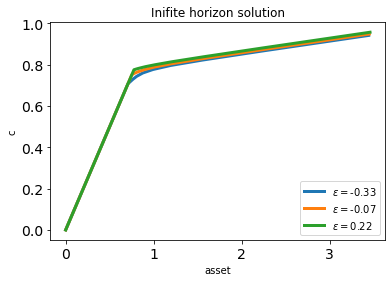

In [14]:
## plot c func at different age /asset grid

eps_ls = [1, 10, 20]

as_inf_star = as_inf_stars[0]
σs_inf_star = σs_inf_stars[0]


for y, eps in enumerate(eps_ls):
    plt.plot(
        as_inf_star[:, eps, 0],
        σs_inf_star[:, eps, 0],
        label=r"$\epsilon=$" + str(round(inf_liv.eps_grid[eps], 2)),
        lw=3,
    )
    plt.legend()
    plt.xlabel("asset")
    plt.ylabel("c")
    plt.title("Inifite horizon solution")

## Infinite horizon with adjustment inertia

In [21]:
## intialize a model instance

imp_adjust = LifeCycle(
    sigma_n=sigma_n,
    sigma_eps=sigma_eps,
    U=U,
    ρ=ρ,
    R=R,
    T=T,
    L=L,
    β=β,
    x=x,
    theta=theta,
    borrowing_cstr=False,
    b_y=b_y,
    unemp_insurance=unemp_insurance,
    adjust_prob=0.6,
)

In [22]:
## initial consumption functions

k = len(imp_adjust.s_grid)
k2 = len(imp_adjust.eps_grid)

n = len(imp_adjust.P)
σ_init = np.empty((k, k2, n))
a_init = np.empty((k, k2, n))

for z in range(n):
    for j in range(k2):
        a_init[:, j, z] = imp_adjust.s_grid
        σ_init[:, j, z] = 0.1 * a_init[:, j, z]

t_start = time()


x_ls = [0.5]
as_imp_stars = []
σs_imp_stars = []
for i, x in enumerate(x_ls):
    ## set different ma parameters
    inf_liv.x = x
    a_imp_star, σ_imp_star = solve_model_iter(imp_adjust, a_init, σ_init)
    as_imp_stars.append(a_imp_star)
    σs_imp_stars.append(σ_imp_star)


t_finish = time()

print("Time taken, in seconds: " + str(t_finish - t_start))

Error at iteration 50 is 0.0003478941543245684.
Error at iteration 100 is 2.2092478174196017e-05.
Error at iteration 150 is 2.0776404502376167e-06.

Converged in 165 iterations.
Time taken, in seconds: 5.432771682739258


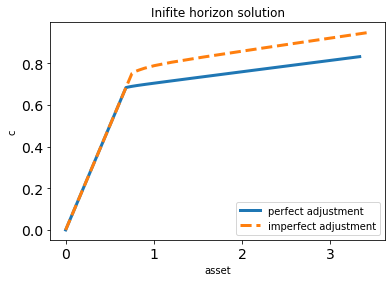

In [23]:
## plot c func at different age /asset grid

eps_ls = [10]

as_imp_star = as_imp_stars[0]
σs_imp_star = σs_imp_stars[0]


for y, eps in enumerate(eps_ls):
    plt.plot(
        as_imp_star[:, eps, 0],
        σs_imp_star[:, eps, 0],
        "-",
        label="perfect adjustment",
        lw=3,
    )
    plt.plot(
        as_inf_star[:, eps, 0],
        σs_inf_star[:, eps, 0],
        "--",
        label="imperfect adjustment",
        lw=3,
    )
    plt.legend()
    plt.xlabel("asset")
    plt.ylabel("c")
    plt.title("Inifite horizon solution")

## Life-Cycle Problem 

### Consumption  the last period 

In [19]:
## this is the retirement consumption policy


def policyPF(β, ρ, R, T, L):
    c_growth = β ** (1 / ρ) * R ** (1 / ρ - 1)
    return (1 - c_growth) / (1 - c_growth ** (L - T))

In [20]:
## intialize a model instance


lc = LifeCycle(
    sigma_n=sigma_n,
    sigma_eps=sigma_eps,
    U=U,
    ρ=ρ,
    R=R,
    T=T,
    L=L,
    β=β,
    x=x,
    theta=theta,
    borrowing_cstr=False,
    b_y=b_y,
    unemp_insurance=unemp_insurance,
)

In [21]:
# Initial the end-of-period consumption policy of σ = consume all assets

# mpc_ret = policyPF(lc.β,
#                   lc.ρ,
#                   lc.R,
#                   lc.T,
#                   lc.L)
# ratio = mpc_ret/(1-mpc_ret)


## initial consumption functions

k = len(lc.s_grid)
k2 = len(lc.eps_grid)

n = len(lc.P)
σ_init = np.empty((k, k2, n))
a_init = np.empty((k, k2, n))

for z in range(n):
    for j in range(k2):
        a_init[:, j, z] = lc.s_grid
        σ_init[:, j, z] = a_init[:, j, z]

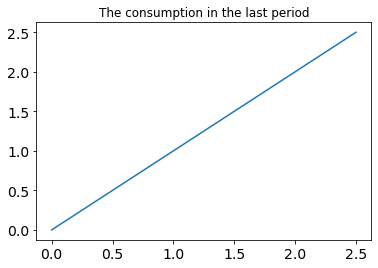

In [22]:
plt.title("The consumption in the last period")
plt.plot(σ_init[:, 1, 1], a_init[:, 1, 1])

### With/without MA idiosyncratic income shock 

In [26]:
## solve the model for a range of ma(1) coefficients
### x!=0, adds the transitory shock an additional state variable

t_start = time()

x_ls = [0.0]
as_stars = []
σs_stars = []
for i, x in enumerate(x_ls):
    lc.x = x
    as_star, σs_star = solve_model_backward_iter(lc, a_init, σ_init)
    as_stars.append(as_star)
    σs_stars.append(σs_star)


t_finish = time()

print("Time taken, in seconds: " + str(t_finish - t_start))

at work age of 40
objective model without stochastic risk
at work age of 39
objective model without stochastic risk
at work age of 38
objective model without stochastic risk
at work age of 37
objective model without stochastic risk
at work age of 36
objective model without stochastic risk
at work age of 35
objective model without stochastic risk
at work age of 34
objective model without stochastic risk
at work age of 33
objective model without stochastic risk
at work age of 32
objective model without stochastic risk
at work age of 31
objective model without stochastic risk
at work age of 30
objective model without stochastic risk
at work age of 29
objective model without stochastic risk
at work age of 28
objective model without stochastic risk
at work age of 27
objective model without stochastic risk
at work age of 26
objective model without stochastic risk
at work age of 25
objective model without stochastic risk
at work age of 24
objective model without stochastic risk
at work age of

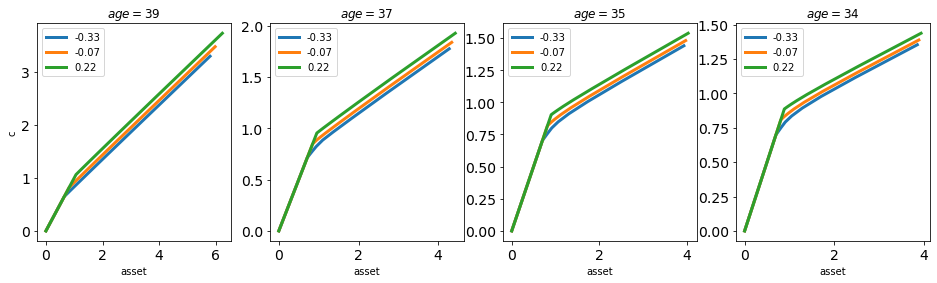

In [27]:
## plot c func at different age /asset grid
years_left = [1, 3, 5, 6]
n_sub = len(years_left)

eps_ls = [1, 10, 20]

as_star = as_stars[0]
σs_star = σs_stars[0]


fig, axes = plt.subplots(1, n_sub, figsize=(4 * n_sub, 4))

for x, year in enumerate(years_left):
    age = lc.T - year
    i = lc.T - age
    for y, eps in enumerate(eps_ls):
        axes[x].plot(
            as_star[i, :, eps, 0],
            σs_star[i, :, eps, 0],
            label=str(round(lc.eps_grid[eps], 2)),
            lw=3,
        )
    axes[x].legend()
    axes[x].set_xlabel("asset")
    axes[0].set_ylabel("c")
    axes[x].set_title(r"$age={}$".format(age))

In [28]:
## interpolate consumption function on continuous s/eps grid

σs_list = []

for i in range(lc.T):
    this_σ = policyfuncMA(lc, as_star[i, :, :, 0], σs_star[i, :, :, 0])
    σs_list.append(this_σ)

Text(0, 0.5, 'ma income shock')

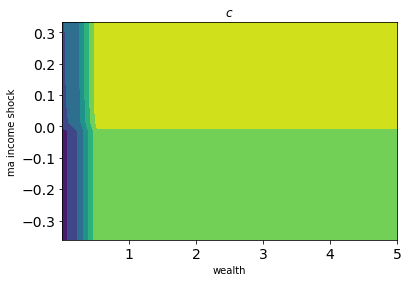

In [29]:
## plot contour for policy function

a_grid = np.linspace(0.00001, 5, 20)
eps_grid = lc.eps_grid
aa, epss = np.meshgrid(a_grid, eps_grid)

σ_this = σs_list[3]
c_stars = σ_this(a_grid, eps_grid)

cp = plt.contourf(aa, epss, c_stars)
plt.title(r"$c$")
plt.xlabel("wealth")
plt.ylabel("ma income shock")

In [30]:
## the size of consumption function is  T x nb_a x nb_eps x nb_z
σs_star.shape

(40, 25, 25, 2)

Text(0.5, 0.92, 'consumption at a certain age')

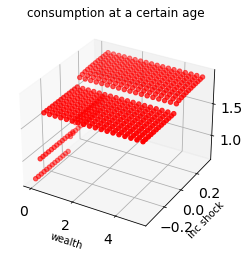

In [31]:
## plot 3d consumption function
# age,asset,inc_shk =σs_star[:,:,:,0]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(aa, epss, c_stars, zdir="z", c="red")
ax.set_xlabel("wealth")
ax.set_ylabel("inc shock")
ax.set_title("consumption at a certain age")

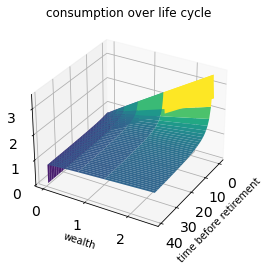

In [32]:
## plot 3d functions over life cycle

ages = np.array(range(as_star.shape[0]))
# ages_id = lc.T-ages
asset = as_star[0, :, 10, 0]
xx, yy = np.meshgrid(ages, asset)
c_stars = σs_star[:, :, 10, 0].T

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
dem3d = ax.plot_surface(
    xx, yy, c_stars, rstride=1, cstride=1, cmap="viridis", edgecolor="none"
)
ax.set_title("consumption over life cycle")
ax.set_xlabel("time before retirement")
ax.set_ylabel("wealth")
ax.view_init(30, 30)

### Different ma persistence

- could be either individual unemployment state or macroeconomic state


Text(0.5, 1.0, 'work age$=4$')

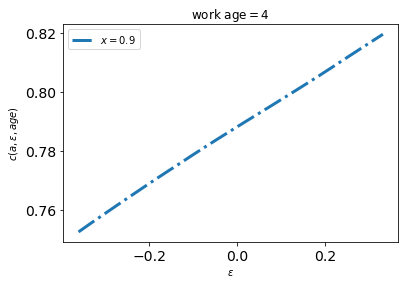

In [33]:
at_age = 4
at_asset_id = 20

for i, x in enumerate(x_ls):
    this_σs_star = σs_stars[i]
    plt.plot(
        lc.eps_grid,
        this_σs_star[lc.T - at_age, at_asset_id, :, 0],
        "-.",
        label=r"$x={}$".format(x),
        lw=3,
    )
plt.legend(loc=0)
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$c(a,\epsilon,age)$")
plt.title(r"work age$={}$".format(at_age))

### With a Markov/persistent unemployment state



In [34]:
## initialize another
lc_uemkv = LifeCycle(
    sigma_n=sigma_n,
    sigma_eps=sigma_eps,
    U=U,
    ρ=ρ,
    R=R,
    T=T,
    L=L,
    β=β,
    x=0.0,  ## shut down ma(1)
    theta=theta,
    borrowing_cstr=False,
    b_y=0.0,  ## markov state loading does not matter any more
    unemp_insurance=0.3,
    ue_markov=True,
)

In [35]:
## solve the model for different transition matricies of UE markov

P = np.array([(0.9, 0.1), (0.2, 0.8)])  # markov transition matricies

t_start = time()

P_ls = [P]
as_stars_uemkv = []
σs_stars_uemkv = []

for i, P in enumerate(P_ls):
    ## feed the model with a markov matrix of macro state
    lc_uemkv.P = P

    ## initial guess
    k = len(lc_uemkv.s_grid)
    k2 = len(lc_uemkv.eps_grid)
    n = len(lc_uemkv.P)

    σ_init_uemkv = np.empty((k, k2, n))
    a_init_uemkv = np.empty((k, k2, n))

    for z in range(n):
        for j in range(k2):
            σ_init_uemkv[:, j, z] = 2 * lc_uemkv.s_grid
            a_init_uemkv[:, j, z] = 2 * lc_uemkv.s_grid

    ## solve the model
    as_star_uemkv, σs_star_uemkv = solve_model_backward_iter(
        lc_uemkv, a_init_uemkv, σ_init_uemkv, sv=False
    )
    as_stars_uemkv.append(as_star_uemkv)
    σs_stars_uemkv.append(σs_star_uemkv)

t_finish = time()

print("Time taken, in seconds: " + str(t_finish - t_start))

at work age of 40
objective model without stochastic risk
at work age of 39
objective model without stochastic risk
at work age of 38
objective model without stochastic risk
at work age of 37
objective model without stochastic risk
at work age of 36
objective model without stochastic risk
at work age of 35
objective model without stochastic risk
at work age of 34
objective model without stochastic risk
at work age of 33
objective model without stochastic risk
at work age of 32
objective model without stochastic risk
at work age of 31
objective model without stochastic risk
at work age of 30
objective model without stochastic risk
at work age of 29
objective model without stochastic risk
at work age of 28
objective model without stochastic risk
at work age of 27
objective model without stochastic risk
at work age of 26
objective model without stochastic risk
at work age of 25
objective model without stochastic risk
at work age of 24
objective model without stochastic risk
at work age of

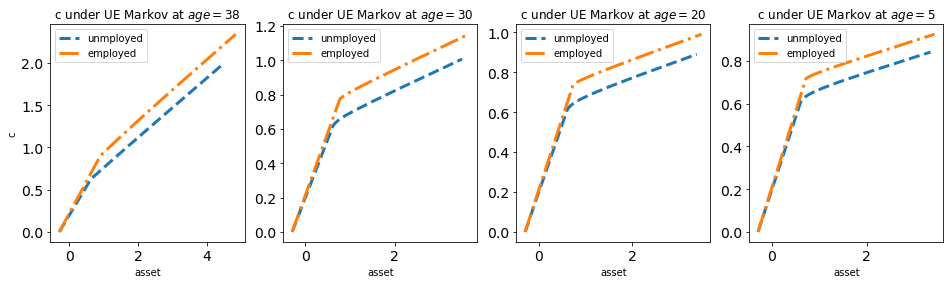

In [36]:
## compare two markov states low versus high risk


years_left = [2, 10, 20, 35]
n_sub = len(years_left)

eps_id = 20

fig, axes = plt.subplots(1, n_sub, figsize=(4 * n_sub, 4))

for x, year in enumerate(years_left):
    age = lc_uemkv.T - year
    i = lc_uemkv.T - age
    axes[x].plot(
        as_stars_uemkv[0][i, :, eps_id, 0],  ## 0 indicates the low risk state
        σs_stars_uemkv[0][i, :, eps_id, 0],
        "--",
        label="unmployed",
        lw=3,
    )
    axes[x].plot(
        as_stars_uemkv[0][i, :, eps_id, 1],  ## 1 indicates the high risk state
        σs_stars_uemkv[0][i, :, eps_id, 1],
        "-.",
        label="employed",
        lw=3,
    )
    axes[x].legend()
    axes[x].set_xlabel("asset")
    axes[0].set_ylabel("c")
    axes[x].set_title(r"c under UE Markov at $age={}$".format(age))

### With a Markov/persistent state: good versus bad 

In [37]:
## initialize another
lc_ρ = LifeCycle(
    sigma_n=sigma_n,
    sigma_eps=sigma_eps,
    U=U,
    ρ=ρ,
    R=R,
    T=T,
    L=L,
    β=β,
    x=0.0,  ## shut down ma(1)
    theta=theta,
    borrowing_cstr=False,
    b_y=1.0,  ## set the macro state loading to be positive
)

In [38]:
## solve the model for different persistence
t_start = time()


ρ_ls = [0.99]
as_stars_ρ = []
σs_stars_ρ = []

for i, ρ in enumerate(ρ_ls):
    ## tauchenize an ar1
    # σ = 0.18
    # constant = 0.00

    # mc = qe.markov.approximation.tauchen(ρ, σ, b=constant, m=3, n=7)
    # z_ss_av = constant/(1-ρ)
    # z_ss_sd = σ*np.sqrt(1/(1-ρ**2))

    ## feed the model with a markov matrix of macro state
    # lc_ρ.z_val, lc_ρ.P = mc.state_values, mc.P
    P = np.array([(0.8, 0.2), (0.05, 0.95)])
    lc_ρ.P = P

    ## initial guess
    k = len(lc_ρ.s_grid)
    k2 = len(lc_ρ.eps_grid)
    n = len(lc_ρ.P)

    σ_init_ρ = np.empty((k, k2, n))
    a_init_ρ = np.empty((k, k2, n))

    for z in range(n):
        for j in range(k2):
            σ_init_ρ[:, j, z] = 2 * lc_ρ.s_grid
            a_init_ρ[:, j, z] = 2 * lc_ρ.s_grid

    ## solve the model
    as_star_ρ, σs_star_ρ = solve_model_backward_iter(lc_ρ, a_init_ρ, σ_init_ρ)
    as_stars_ρ.append(as_star_ρ)
    σs_stars_ρ.append(σs_star_ρ)


t_finish = time()

print("Time taken, in seconds: " + str(t_finish - t_start))

at work age of 40
objective model without stochastic risk
at work age of 39
objective model without stochastic risk
at work age of 38
objective model without stochastic risk
at work age of 37
objective model without stochastic risk
at work age of 36
objective model without stochastic risk
at work age of 35
objective model without stochastic risk
at work age of 34
objective model without stochastic risk
at work age of 33
objective model without stochastic risk
at work age of 32
objective model without stochastic risk
at work age of 31
objective model without stochastic risk
at work age of 30
objective model without stochastic risk
at work age of 29
objective model without stochastic risk
at work age of 28
objective model without stochastic risk
at work age of 27
objective model without stochastic risk
at work age of 26
objective model without stochastic risk
at work age of 25
objective model without stochastic risk
at work age of 24
objective model without stochastic risk
at work age of

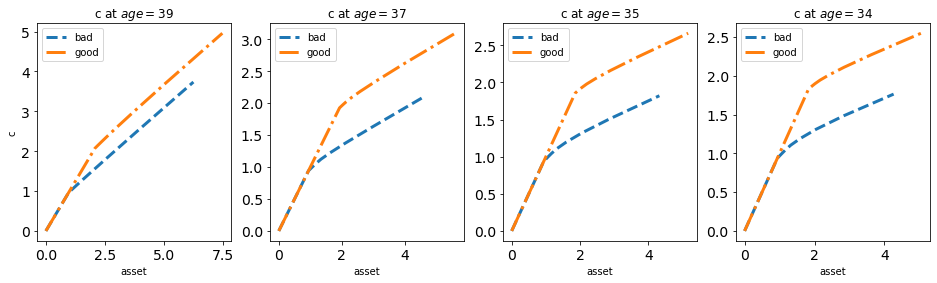

In [39]:
## compare two markov states good versus bad


years_left = [1, 3, 5, 6]
n_sub = len(years_left)


eps_ls = [20]

fig, axes = plt.subplots(1, n_sub, figsize=(4 * n_sub, 4))

for x, year in enumerate(years_left):
    age = lc.T - year
    i = lc.T - age
    for y, eps in enumerate(eps_ls):
        axes[x].plot(
            as_stars_ρ[0][i, :, y, 0],
            σs_stars_ρ[0][i, :, y, 0],
            "--",
            label="bad",
            lw=3,
        )
        axes[x].plot(
            as_stars_ρ[0][i, :, y, 1],
            σs_stars_ρ[0][i, :, y, 1],
            "-.",
            label="good",
            lw=3,
        )
    axes[x].legend()
    axes[x].set_xlabel("asset")
    axes[0].set_ylabel("c")
    axes[x].set_title(r"c at $age={}$".format(age))

### State-dependent risks 

In [ ]:
## transition matrix between low and high risk state

P = np.array([(0.8, 0.2), (0.05, 0.95)])  # markov transition matricies

In [40]:
sigma_n_2mkv = np.array([0.01, 0.01])  ## permanent risks in 2 markov states

sigma_eps_2mkv = np.array([0.05, 0.5])  ## transitory risks in 2 markov states

b_y = 0.0  ## set the macro state loading to be zero, i.e. only risks differ across two states
lc_sv = LifeCycle(
    sigma_n=sigma_n,
    sigma_eps=sigma_eps,
    U=U,
    ρ=ρ,
    P=P,
    R=R,
    T=T,
    L=L,
    β=β,
    sigma_n_2mkv=sigma_n_2mkv,
    sigma_eps_2mkv=sigma_eps_2mkv,
    shock_draw_size=30,
    borrowing_cstr=False,
    x=0.0,  ## shut down ma(1)
    theta=theta,
    b_y=b_y,
)

In [41]:
## solve the model for different transition matricies

t_start = time()

P_ls = [P]
as_stars_sv = []
σs_stars_sv = []

for i, P in enumerate(P_ls):
    ## feed the model with a markov matrix of macro state
    lc_sv.P = P

    ## initial guess
    k = len(lc_sv.s_grid)
    k2 = len(lc_sv.eps_grid)
    n = len(lc_sv.P)

    σ_init_sv = np.empty((k, k2, n))
    a_init_sv = np.empty((k, k2, n))

    for z in range(n):
        for j in range(k2):
            σ_init_sv[:, j, z] = 2 * lc_sv.s_grid
            a_init_sv[:, j, z] = 2 * lc_sv.s_grid

    ## solve the model
    as_star_sv, σs_star_sv = solve_model_backward_iter(
        lc_sv, a_init_sv, σ_init_sv, sv=True
    )
    as_stars_sv.append(as_star_sv)
    σs_stars_sv.append(σs_star_sv)

t_finish = time()

print("Time taken, in seconds: " + str(t_finish - t_start))

at work age of 40
objective model with stochastic risk
at work age of 39
objective model with stochastic risk
at work age of 38
objective model with stochastic risk
at work age of 37
objective model with stochastic risk
at work age of 36
objective model with stochastic risk
at work age of 35
objective model with stochastic risk
at work age of 34
objective model with stochastic risk
at work age of 33
objective model with stochastic risk
at work age of 32
objective model with stochastic risk
at work age of 31
objective model with stochastic risk
at work age of 30
objective model with stochastic risk
at work age of 29
objective model with stochastic risk
at work age of 28
objective model with stochastic risk
at work age of 27
objective model with stochastic risk
at work age of 26
objective model with stochastic risk
at work age of 25
objective model with stochastic risk
at work age of 24
objective model with stochastic risk
at work age of 23
objective model with stochastic risk
at work ag

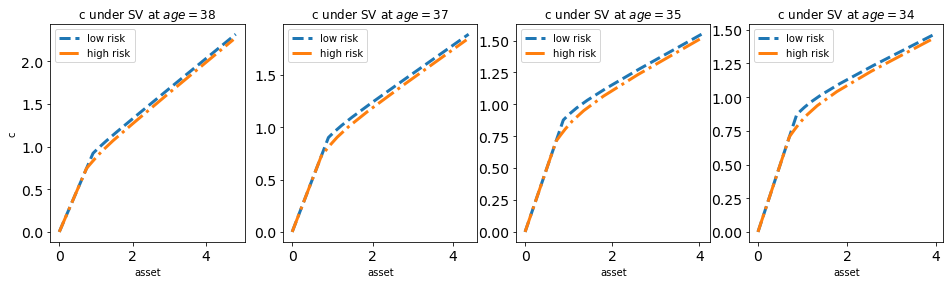

In [42]:
## compare two markov states low versus high risk


years_left = [2, 3, 5, 6]
n_sub = len(years_left)

eps_id = 20

fig, axes = plt.subplots(1, n_sub, figsize=(4 * n_sub, 4))

for x, year in enumerate(years_left):
    age = lc.T - year
    i = lc.T - age
    axes[x].plot(
        as_stars_sv[0][i, :, eps_id, 0],  ## 0 indicates the low risk state
        σs_stars_sv[0][i, :, eps_id, 0],
        "--",
        label="low risk",
        lw=3,
    )
    axes[x].plot(
        as_stars_sv[0][i, :, eps_id, 1],  ## 1 indicates the high risk state
        σs_stars_sv[0][i, :, eps_id, 1],
        "-.",
        label="high risk",
        lw=3,
    )
    axes[x].legend()
    axes[x].set_xlabel("asset")
    axes[0].set_ylabel("c")
    axes[x].set_title(r"c under SV at $age={}$".format(age))

### "Countercylical" risks


In [2]:
b_y = 0.0

lc_cr = LifeCycle(
    sigma_n=sigma_n,
    sigma_eps=sigma_eps,
    U=U,
    ρ=ρ,
    P=P,
    R=R,
    T=T,
    L=L,
    β=β,
    sigma_n_2mkv=sigma_n_2mkv,
    sigma_eps_2mkv=sigma_eps_2mkv,
    shock_draw_size=30,
    borrowing_cstr=False,
    x=0.0,  ## shut down ma(1)
    theta=theta,
    b_y=b_y,  ## set the macro state loading to be zero, i.e. only risks differ across two states,
    ue_markov=True,
)

NameError: name 'LifeCycle' is not defined

In [44]:
## solve the model for different transition matricies

t_start = time()

P_ls = [P]
as_stars_cr = []
σs_stars_cr = []

for i, P in enumerate(P_ls):
    ## feed the model with a markov matrix of macro state
    lc_cr.P = P

    ## initial guess
    k = len(lc_cr.s_grid)
    k2 = len(lc_cr.eps_grid)
    n = len(lc_cr.P)

    σ_init_cr = np.empty((k, k2, n))
    a_init_cr = np.empty((k, k2, n))

    for z in range(n):
        for j in range(k2):
            σ_init_cr[:, j, z] = 2 * lc_cr.s_grid
            a_init_cr[:, j, z] = 2 * lc_cr.s_grid

    ## solve the model
    as_star_cr, σs_star_cr = solve_model_backward_iter(
        lc_cr, a_init_cr, σ_init_cr, sv=True
    )
    as_stars_cr.append(as_star_cr)
    σs_stars_cr.append(σs_star_cr)

t_finish = time()

print("Time taken, in seconds: " + str(t_finish - t_start))

at work age of 40
objective model with stochastic risk
at work age of 39
objective model with stochastic risk
at work age of 38
objective model with stochastic risk
at work age of 37
objective model with stochastic risk
at work age of 36
objective model with stochastic risk
at work age of 35
objective model with stochastic risk
at work age of 34
objective model with stochastic risk
at work age of 33
objective model with stochastic risk
at work age of 32
objective model with stochastic risk
at work age of 31
objective model with stochastic risk
at work age of 30
objective model with stochastic risk
at work age of 29
objective model with stochastic risk
at work age of 28
objective model with stochastic risk
at work age of 27
objective model with stochastic risk
at work age of 26
objective model with stochastic risk
at work age of 25
objective model with stochastic risk
at work age of 24
objective model with stochastic risk
at work age of 23
objective model with stochastic risk
at work ag

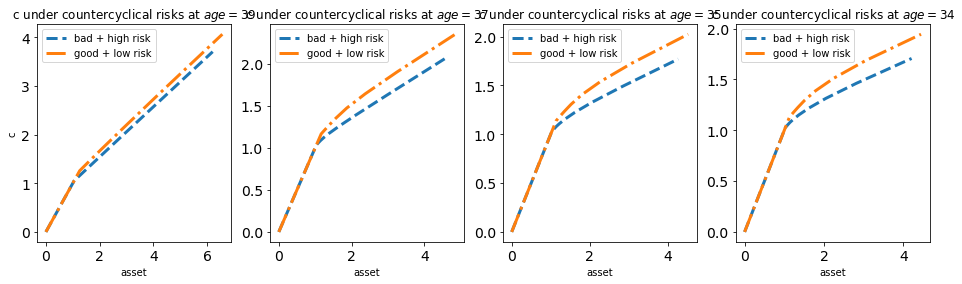

In [45]:
## compare two markov states low versus high risk


years_left = [1, 3, 5, 6]
n_sub = len(years_left)

eps_id = 20

fig, axes = plt.subplots(1, n_sub, figsize=(4 * n_sub, 4))

for x, year in enumerate(years_left):
    age = lc.T - year
    i = lc.T - age
    axes[x].plot(
        as_stars_cr[0][i, :, eps_id, 0],  ## 0 indicates the low risk state
        σs_stars_cr[0][i, :, eps_id, 0],
        "--",
        label="bad + high risk",
        lw=3,
    )
    axes[x].plot(
        as_stars_cr[0][i, :, eps_id, 1],  ## 1 indicates the high risk state
        σs_stars_cr[0][i, :, eps_id, 1],
        "-.",
        label="good + low risk",
        lw=3,
    )
    axes[x].legend()
    axes[x].set_xlabel("asset")
    axes[0].set_ylabel("c")
    axes[x].set_title(r"c under countercyclical risks at $age={}$".format(age))

### Subjective perceptions 

In [46]:
## solve for subjective agent
## agents extrapolate recent tarnsitory volatility to perceptions

t_start = time()


as_br, σs_br = solve_model_backward_iter(
    lc, a_init, σ_init, br=True
)  ## bounded rationality is true


t_finish = time()

print("Time taken, in seconds: " + str(t_finish - t_start))

at work age of 40
subjective model with stochastic risk
at work age of 39
subjective model with stochastic risk
at work age of 38
subjective model with stochastic risk
at work age of 37
subjective model with stochastic risk
at work age of 36
subjective model with stochastic risk
at work age of 35
subjective model with stochastic risk
at work age of 34
subjective model with stochastic risk
at work age of 33
subjective model with stochastic risk
at work age of 32
subjective model with stochastic risk
at work age of 31
subjective model with stochastic risk
at work age of 30
subjective model with stochastic risk
at work age of 29
subjective model with stochastic risk
at work age of 28
subjective model with stochastic risk
at work age of 27
subjective model with stochastic risk
at work age of 26
subjective model with stochastic risk
at work age of 25
subjective model with stochastic risk
at work age of 24
subjective model with stochastic risk
at work age of 23
subjective model with stochast

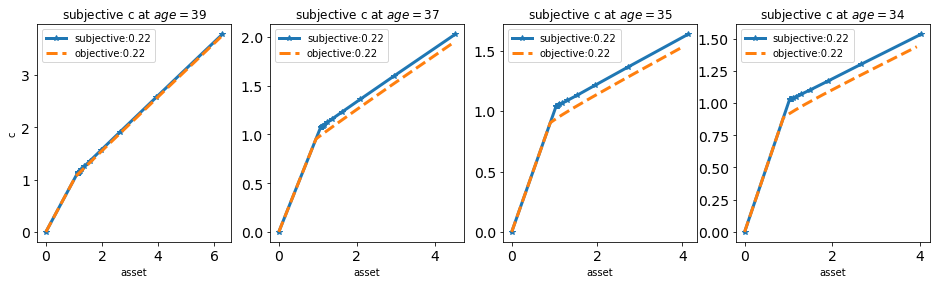

In [47]:
## compare subjective and objective model
years_left = [1, 3, 5, 6]
n_sub = len(years_left)

eps_ls = [20]

fig, axes = plt.subplots(1, n_sub, figsize=(4 * n_sub, 4))

for x, year in enumerate(years_left):
    age = lc.T - year
    i = lc.T - age
    for y, eps in enumerate(eps_ls):
        axes[x].plot(
            as_br[i, :, eps, 0],
            σs_br[i, :, eps, 0],
            "*-",
            label="subjective:" + str(round(lc.eps_grid[eps], 2)),
            lw=3,
        )
        axes[x].plot(
            as_star[i, :, eps, 0],
            σs_star[i, :, eps, 0],
            "--",
            label="objective:" + str(round(lc.eps_grid[eps], 2)),
            lw=3,
        )
    axes[x].legend()
    axes[x].set_xlabel("asset")
    axes[0].set_ylabel("c")
    axes[x].set_title(r"subjective c at $age={}$".format(age))

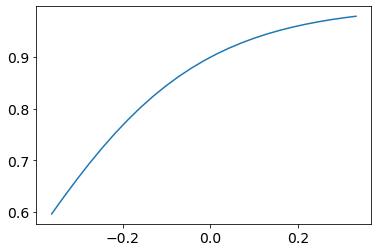

In [48]:
x_sj = extrapolate(5, lc.x, lc.eps_grid)  ## sj: subjective

plt.plot(lc.eps_grid, x_sj)

Text(0.5, 1.0, 'subjectiv c at work age$=10$')

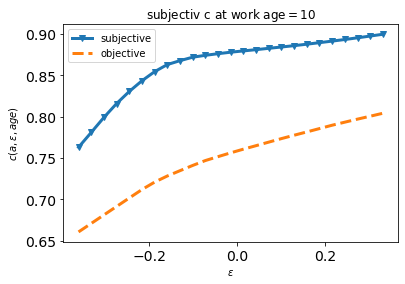

In [51]:
at_age = 10
at_asset_id = 15

plt.plot(
    lc.eps_grid, σs_br[lc.T - at_age, at_asset_id, :, 0], "v-", label="subjective", lw=3
)
plt.plot(
    lc.eps_grid,
    σs_star[lc.T - at_age, at_asset_id, :, 0],
    "--",
    label="objective",
    lw=3,
)
plt.legend(loc=0)
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$c(a,\epsilon,age)$")
plt.title(r"subjectiv c at work age$={}$".format(at_age))

### Comparing consumptions under different assumptions

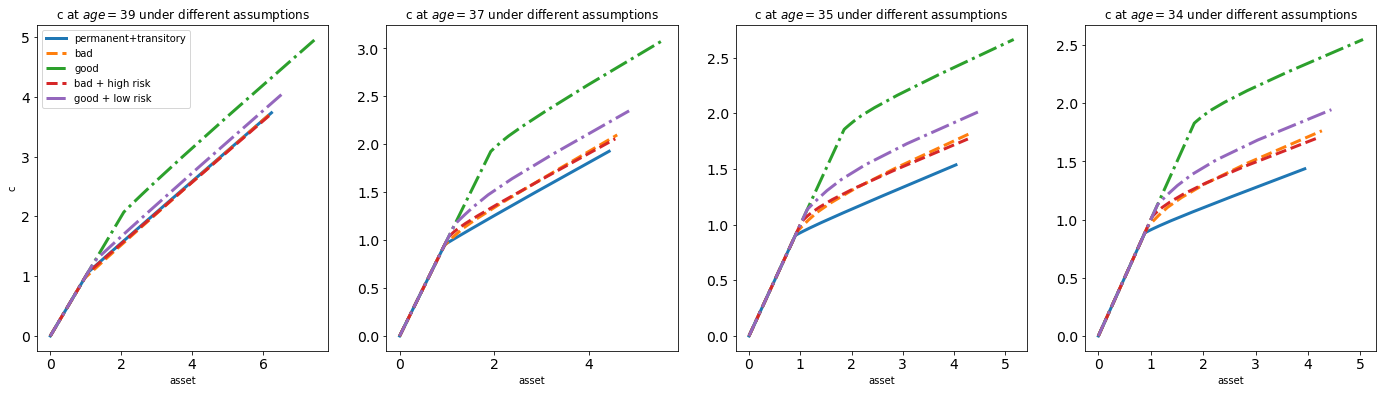

In [50]:
## compare subjective and objective models
years_left = [1, 3, 5, 6]
n_sub = len(years_left)

eps_ls = [20]

fig, axes = plt.subplots(1, n_sub, figsize=(6 * n_sub, 6))

for x, year in enumerate(years_left):
    age = lc.T - year
    i = lc.T - age
    for y, eps in enumerate(eps_ls):
        ## baseline: no ma shock
        axes[x].plot(
            as_star[i, :, eps, 0],
            σs_star[i, :, eps, 0],
            label="permanent+transitory",
            lw=3,
        )
        ## persistent
        axes[x].plot(
            as_stars_ρ[0][i, :, y, 0],
            σs_stars_ρ[0][i, :, y, 0],
            "--",
            label="bad",
            lw=3,
        )
        axes[x].plot(
            as_stars_ρ[0][i, :, y, 1],
            σs_stars_ρ[0][i, :, y, 1],
            "-.",
            label="good",
            lw=3,
        )
        ## stochastic volatility
        # axes[x].plot(as_stars_sv[0][i,:,eps_id,0], ## 0 indicates the low risk state
        #             σs_stars_sv[0][i,:,eps_id,0],
        #             '--',
        #             label ='low risk',
        #             lw=3)
        # axes[x].plot(as_stars_sv[0][i,:,eps_id,1], ## 1 indicates the high risk state
        #             σs_stars_sv[0][i,:,eps_id,1],
        #             '-.',
        #             label ='high risk',
        #             lw=3)
        ## countercyclical
        axes[x].plot(
            as_stars_cr[0][i, :, eps_id, 0],  ## 0 indicates the low risk state
            σs_stars_cr[0][i, :, eps_id, 0],
            "--",
            label="bad + high risk",
            lw=3,
        )
        axes[x].plot(
            as_stars_cr[0][i, :, eps_id, 1],  ## 1 indicates the high risk state
            σs_stars_cr[0][i, :, eps_id, 1],
            "-.",
            label="good + low risk",
            lw=3,
        )
        ## subjective
        # axes[x].plot(as_br[i,:,eps,0],
        #             σs_br[i,:,eps,0],
        #             '*-',
        #             label = 'subjective:'+str(round(lc.eps_grid[eps],2)),
        #             lw=3)
        # axes[x].plot(as_star[i,:,eps,0],
        #             σs_star[i,:,eps,0],
        #             '--',
        #             label ='objective:'+str(round(lc.eps_grid[eps],2)),
        #             lw=3)

    axes[0].legend()
    axes[x].set_xlabel("asset")
    axes[0].set_ylabel("c")
    axes[x].set_title(r"c at $age={}$ under different assumptions".format(age))